# Introdução 

Nesse tutorial vamos aprender o básico sobre as etapas de uma rotina de ETL(extract, transform and load). A ideia aqui é utilizar um dataset público real para demonstrar como implementar as diferentes etapas dessa rotina. Vamos explorar alguns conceitos básicos da Engenharia de dados, como implementar rotinas para extração de arquivos e como manipular dados com o Pandas. Lembrando que toda a implementação aqui é focada em *small data*.

# O que é ETL

**ETL(Extract, transform and load)** é um processo que consiste em integrar dados de diferentes fontes buscando consolidá-los de uma maneira que facilite o processo de análise. O termo se popularizou com o surgimento das *data warehouses*, que nasceram da necessidade de centralizar diversas fontes de dados para permitir criar análises que ajudassem as empresas na tomada de decisão.

O processo consiste de três etapas:

1. *Extract*: extrair dados de uma fonte de informações, seja banco de dados, API, arquivos, etc. Para serem processados posteriormente;
2. *Transform*: nessa etapa os dados extraídos passam por uma transformação para atender os requisitos das aplicações cliente. A transormação envolve:
    - Limpar e validar os dados para garantir qualidade;
    - Transformar o formato dos dados para, por exemplo, facilitar usabilidade e busca;
    - Combinar diferentes fontes para compor as informações necessárias;
    - Aplicar regras de negócio.
3. *Load*: carregar resultado das transformações no sistema de destino, como *date warehouses* ou *data lakes*.

![](./img/etl_diagram.png)

# Data warehouse e data lake 

**Data warehouses**, segundo Bill Inmon, é uma coleção de dados orientada à assunto, não volátil, integrada e variável no tempo para apoiar as decisões de negócio. Exemplos de ferramentas em nuvem:

<div style="background-color: white">
  <img src="./img/redshift.png" width="300px" style="margin-right: 10rem;">
   <img src="./img/bigquery.png" width="300px">
</div>


**Data lake** é um repositório que permite armazenar dados estruturados e não estruturados em qualquer escala. Opções de ferramentas para utilizar como storage para data lakes:

<div style="background-color: white">
  <img src="./img/s3.png" style="width: 200px; margin-right: 10rem;">
  <img src="./img/gcs.png" style="width: 200px; margin-right: 10rem;">
  <img src="./img/azure_storage.png" style="width: 300px">
</div>

# Pandas 

Biblioteca Python open-source para análise e manipulação de dados. Começou a ser desenvolvida em 2008 e se tornou [open-source](https://github.com/pandas-dev/pandas) em 2009.

![](./img/pandasgh.png)

# A fonte de dados 

Vamos trabalhar com a fonte de dados abertos da [Comissão de Valores Mobiliários](http://www.cvm.gov.br/) contendo a cotação diária dos fundos de investimentos negociados no mercado brasileiro. Essa fonte é atualizada diariamente com os dados de fechamento do dia anterior e as cotações são agrupadas por arquivos correspondentes a cada mês do ano.

Esse é um cenário bem comum em fontes de dados abertas, uma série de arquivos no formato CSV agrupando informações de acordo com a data, então a solução que vamos implementar durante o tutorial é reaproveitável para outras fontes de dados.

Primeiro é importante analisar a fonte de dados, entender como ela está estruturada, quais campos compõem o dataset e como nós podemos automatizar a coleta dos dados.

A fonte de dados contendo a cotação diária dos fundos pode ser acessada através do portal de dados abertos pelo link:

http://www.dados.gov.br/dataset/fi-doc-inf_diario

# ETL

In [99]:
import pandas as pd
import requests
from tqdm import tqdm

## Extrair 

O processo de extração consiste nesse caso em fazer o download de todos os arquivos da janela de tempo q nos interessa. Para isso precisamos gerar o nome dos arquivos com as datas da janela de tempo no formato esperado.

### Gera lista de datas

In [103]:
def generate_dates(start, end, freq='M', format='%Y%m'):
    return [date.strftime(format) for date in pd.date_range(start=start, end=end, freq=freq)]

In [113]:
date_list = generate_dates('2020-01', '2020-02')

### Requisita e salva os arquivos 

In [114]:
def extract(date_list):
    base_url = 'http://dados.cvm.gov.br/dados/FI/DOC/INF_DIARIO/DADOS/inf_diario_fi_{date}.csv'
    
    dfs = [pd.read_csv(base_url.format(date=date), sep=';') for date in date_list]
    return pd.concat(dfs)

In [115]:
df_extract = extract(date_list)

In [116]:
df_extract.head()

,CNPJ_FUNDO,DT_COMPTC,VL_TOTAL,VL_QUOTA,VL_PATRIM_LIQ,CAPTC_DIA,RESG_DIA,NR_COTST
0,00.017.024/0001-53,2020-01-02,1132491.66,27.225023,1123583.00,0.0,0.0,1
1,00.017.024/0001-53,2020-01-03,1132685.12,27.224496,1123561.25,0.0,0.0,1
2,00.017.024/0001-53,2020-01-06,1132881.43,27.225564,1123605.31,0.0,0.0,1
3,00.017.024/0001-53,2020-01-07,1133076.85,27.226701,1123652.24,0.0,0.0,1
4,00.017.024/0001-53,2020-01-08,1132948.59,27.227816,1123698.26,0.0,0.0,1


## Análise

Aqui vou abrir um parênteses para uma análise rápido do nosso dateframe, é claro que só a parte de exploração dos dados vale um tutorial completo, então não vou explorar muito esses aspecto aqui, mas de qualquer forma é importante ter noção de alguns pontos básicos quando se trabalha com uma fonte de dados:

- Qual o tipo de cada coluna
- Quantos valores nulos que existem
- Como estão formatados

Essa etapa não faz parte do ETL, na verdade essa exploração inicial normalmente é feita antes de construir a *pipeline* para entender a fonte de dados utilizada.

In [117]:
# Formato do dataframe (linhas, colunas)
df_extract.shape

(369894, 8)

In [118]:
# Quais são nossas colunas, seus tipos e se existem valores nulos
df_extract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 369894 entries, 0 to 369893
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   CNPJ_FUNDO     369894 non-null  object 
 1   DT_COMPTC      369894 non-null  object 
 2   VL_TOTAL       369894 non-null  float64
 3   VL_QUOTA       369894 non-null  float64
 4   VL_PATRIM_LIQ  369894 non-null  float64
 5   CAPTC_DIA      369894 non-null  float64
 6   RESG_DIA       369894 non-null  float64
 7   NR_COTST       369894 non-null  int64  
dtypes: float64(5), int64(1), object(2)
memory usage: 22.6+ MB


In [120]:
print('Quantidade de fundos:', df_extract.CNPJ_FUNDO.unique().size)

Quantidade de fundos: 16977


In [125]:
# Preview do DataFrame
df_extract.head()

,CNPJ_FUNDO,DT_COMPTC,VL_TOTAL,VL_QUOTA,VL_PATRIM_LIQ,CAPTC_DIA,RESG_DIA,NR_COTST
0,00.017.024/0001-53,2020-01-02,1132491.66,27.225023,1123583.00,0.0,0.0,1
1,00.017.024/0001-53,2020-01-03,1132685.12,27.224496,1123561.25,0.0,0.0,1
2,00.017.024/0001-53,2020-01-06,1132881.43,27.225564,1123605.31,0.0,0.0,1
3,00.017.024/0001-53,2020-01-07,1133076.85,27.226701,1123652.24,0.0,0.0,1
4,00.017.024/0001-53,2020-01-08,1132948.59,27.227816,1123698.26,0.0,0.0,1


<AxesSubplot:xlabel='DT_COMPTC'>

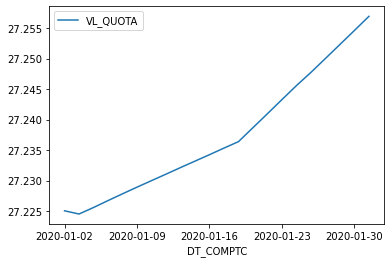

In [127]:
df_extract[df_extract.CNPJ_FUNDO == '00.017.024/0001-53'].plot(x='DT_COMPTC', y='VL_QUOTA')

## Transformar 

Nessa etapa é necessário consolidar todas as informações extraídas, aplicar os tratamentos e regras de negócio que fazem sentido para a aplicação cliente, defini alguns objetivos para nos orientar durante essa etapa:

1. Manter somente fundos com mais de `1000` cotistas;
2. Mudar o formato do dataframe para:


|            | 00.017.024/0001-53 | 97.929.213/0001-34 | 00.068.305/0001-35 | ... |
|------------|--------------------|--------------------|--------------------|-----|
| 2020-01-02 | 27.225023          | 27.112737          | 1.733476e+08       | ... |
| 2020-01-03 | 27.224496          | 27.115661          | 6.611408e+07       | ... |
| ...        | ...                | ...                | ...                | ... |

In [128]:
df_extract.DT_COMPTC = pd.to_datetime(df_extract.DT_COMPTC, format='%Y-%m-%d')

In [130]:
def filter_by_shareholders(df, qtd_shareholders = 1000):
    df_final_date = df[df.DT_COMPTC == df.DT_COMPTC.max()]
    valid_cnpjs = df_final_date.query('NR_COTST >= @qtd_shareholders').CNPJ_FUNDO
    return df.query('CNPJ_FUNDO in @valid_cnpjs')

In [150]:
def transform(data):
    data.DT_COMPTC = pd.to_datetime(data.DT_COMPTC, format='%Y-%m-%d')
    return (data.pipe(filter_by_shareholders)
                .pipe(pd.pivot, index='DT_COMPTC', columns='CNPJ_FUNDO', values='VL_QUOTA'))

In [135]:
df_transform = transform(df_extract)

In [137]:
df_transform.head()

CNPJ_FUNDO,00.068.305/0001-35,00.071.477/0001-68,00.180.995/0001-10,00.222.725/0001-24,00.222.816/0001-60,00.280.302/0001-60,00.306.278/0001-91,00.322.699/0001-06,00.360.293/0001-18,00.398.561/0001-90,...,67.976.449/0001-60,68.599.141/0001-06,68.623.479/0001-56,68.670.512/0001-07,68.971.183/0001-26,73.899.759/0001-21,88.002.696/0001-36,88.198.056/0001-43,97.519.703/0001-62,97.519.794/0001-36
DT_COMPTC,,,,,,,,,,,,,,,,,,,,,
2020-01-02,27.112737,9.979337,550.381807,3695.421072,7689.303576,4696.049724,18.811236,13.041650,22.378766,227.998183,...,12.634536,4.013766,5.693611,1.864455,1.100212,40.429076,0.711309,6107.57366,22.081756,21.002109
2020-01-03,27.115661,9.979770,550.468081,3697.159049,7690.674711,4696.806615,18.813887,13.043727,22.501972,225.529173,...,12.541972,4.013966,5.694228,1.853287,1.100384,40.128902,0.709291,6119.45635,22.085839,21.005407
2020-01-06,27.118216,9.980323,550.475403,3697.272064,7690.802997,4697.423331,18.816628,13.045941,22.544107,223.095944,...,12.452326,4.014164,5.694767,1.816770,1.100555,39.842954,0.703597,6091.10393,22.089976,21.008664
2020-01-07,27.121996,9.980816,550.688536,3697.922105,7694.073773,4698.291493,18.819392,13.047728,22.593079,223.376967,...,12.428292,4.014379,5.695564,1.816762,1.100703,39.768262,0.702067,6132.30651,22.095126,21.011485
2020-01-08,27.126159,9.981363,550.899190,3698.652972,7697.353404,4699.138945,18.822258,13.050008,22.501116,223.389476,...,12.382488,4.014584,5.696441,1.814723,1.100884,39.617461,0.698760,6130.89475,22.099806,21.014944


## Carregar 

Para etapa de carregamento vamos exportar o resultado em formato CSV e também vou demostrar como subir esse arquivo no [S3 da Amazon](https://aws.amazon.com/pt/s3/), que é um serviço de armazenamento de objetos na cloud, comumente usado como *data lake*.

In [140]:
# Exportar resultado para arquivo CSV
df_transform.to_csv('result.csv')

**Bônus**: Essa função utiliza do SDK do AWS para fazer o upload do arquivo resultante em um *bucket* no S3 da AWS, não vou entrar em detalhes sobre a configuração dessa ferramenta, mas se tiver interesse em saber mais a [documentação do boto3](https://boto3.amazonaws.com/v1/documentation/api/latest/guide/quickstart.html#installation) tem um passo a passo sobre como utilizar o SDK.

In [145]:
import boto3

def load(data, remote_file_name, bucket):
    # Carregar resultado no S3
    
    s3 = boto3.resource('s3')
    return s3.Bucket(bucket).put_object(Key=remote_file_name, Body=data.to_csv())

In [146]:
load(df_transform, 'fretalks.csv', 'fretalks')

s3.Object(bucket_name='fretalks', key='fretalks.csv')

## Consolidando 

In [153]:
def pipeline_etl(since, to, s3_bucket):
    date_list = generate_dates(since, to)
    file_name = 'fi_info_diario_{}_{}.csv'.format(since, to)
    
    data_extract = extract(date_list)
    data_transform = transform(data_extract)
    return load(data_transform, file_name, s3_bucket)

In [154]:
pipeline_etl('2020-01-01', '2020-03-01', 'fretalks')

s3.Object(bucket_name='fretalks', key='fi_info_diario_2020-01-01_2020-03-01.csv')

# Conclusão

Durante o tutorial passamos por todas as etapas do processo ETL, claro que a solução que implementamos aqui é simples e trabalha com um pequeno volume de dados, a partir do momento em que o volume de dados aumenta é preciso buscar ferramentas otimizadas, mas o processo no geral continua o mesmo. E para levar essa *pipeline* para produção o que falta? 

Em produção é importante utilizar ferramentas que paralelizem a execução das tarefas e que também sejam capazes de lidar com falhas durante o processo, no caso de *pipelines* que realizam processamento em lote(como a que nós implementamos), temos por exemplo ferramentas como:
- [Apache Airflow](https://airflow.apache.org/)
- [Luigi](https://github.com/spotify/luigi)
- [Apache Beam](https://beam.apache.org/)
- [Prefect](https://www.prefect.io/)

Exemplo de pipeline que utiliza dessa mesma fonte, e mais algumas, sendo executada no [Apache Airflow](https://airflow.apache.org/):

![](img/airflow_dag.png)

Pra quem quiser se informar(não é recomendação) sobre oportunidades de investimento de uma maneira mais simples, tem o grupo da Sharke no telegram:

https://t.me/SharkeInvestimentos